# Kernel Non-Negative Tensor Factorization

In [12]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy.io as sio #to load mat files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

<h1> 1. Loading CMU Faces dataset </h1>

$\mathcal{X}\in\mathbb{R}_+^{30\times11\times21\times1024}$

In [13]:
sio.whosmat('../datasets/CMU(30x11x21x1024).mat')

[('FullTensor', (30, 11, 21, 1024), 'uint8')]

In [4]:
matTF = sio.loadmat('../datasets/CMU(30x11x21x1024).mat')#loading tensor of formatted faces' images

In [5]:
TF = matTF['FullTensor']
print TF.shape

(30, 11, 21, 1024)


Tensor Matrization:

$X\in\mathbb{R}_+^{6930\times1024}$

In [6]:
MF = np.reshape(TF,(30*11*21,1024))
print MF.shape

(6930, 1024)


<h2>1.1 Preprocessing incomplete data</h2>

In [7]:
rt_obinc = 0.4 # rate of objects incomplete
rt_incpob = 0.5 # rate of minimun elements (attributes or variables) incomplete for each object
idx_inc = np.sort(np.random.choice(MF.shape[0], MF.shape[0]*rt_obinc, replace=False))
idx_v = np.ones(MF.shape[0])
idx_v[idx_inc] = 0
idx_s = np.vstack((idx_v,idx_v)).repeat([1,MF.shape[1]-1],0).T
idx_com = np.arange(0,MF.shape[0]-1)
idx_com = np.delete(idx_com, idx_inc)

In [8]:
idx_s2 = np.copy(idx_s) # idx_s2 could have partially incomplete objects
for i in idx_inc:
    idx_s2[i] = np.random.permutation(np.append(np.random.randint(2,size=MF.shape[1]*(1-rt_incpob)),np.zeros(MF.shape[1]*rt_incpob)))

#plt.pcolor(idx_s2)
#plt.colorbar()

In [9]:
MF_ci = MF * idx_s2
MF_i = MF_ci[idx_inc]#subset with incomplete elements
MF_c = MF_ci[idx_com]#subset with complete elements
#plt.pcolor(MF_ci)
#plt.colorbar()

<h1>2. Kernel Completion Using Convex-NMF </h1>

In [16]:
import kernel as kernel
import pymf
from pymf.cnmf import CNMF 
import time

<h2>2.1 Tensorial Kernel for CMU Faces</h2>

 <ul style="list-style-type:disc">
  <li>Subject: SoftKernel $K_s$</li>
  <li>Pose: rbf kernel $K_p$</li>
  <li>Illumination: : rbf kernel $K_l$</li>
  <li>Image: linear kernel $K_i$</li>
</ul> 

In [18]:
#30x11x21x1024
eq = 1
diff = 0.3
poses = [175, 95, 93, 88, 10, 5, 180, 90, 80, 2, 170]
illuminations = np.arange(1,22)
TS = np.zeros((30,11,21))
for i in range(30):
    for j in range(len(poses)):
        for k in range(len(illuminations)):
            TS[i,j,k] = i
            
MS = np.reshape(TS,(30*11*21,1))

In [19]:
#Kernel for subject
Ks = np.zeros((len(idx_com),len(idx_com)))
for i in range(len(idx_com)):
    for j in range(len(idx_com)):
        if MS[i]==MS[j]:
            Ks[i,j] = eq
        else:
            Ks[i,j] = diff
print Ks.shape        
#plt.pcolor(Ks[350:,350:])
#plt.colorbar()

(4157, 4157)


In [20]:
TL_ = np.repeat(np.array(np.arange(1,22), ndmin = 2),11,axis=0)
TL = np.repeat(np.array(TL_,ndmin = 3),30,axis=0)
print TL.shape
ML = np.reshape(TL,(30*11*21,1))
print ML.shape
ML_c = ML[idx_com]
print ML_c.shape

(30, 11, 21)
(6930, 1)
(4157, 1)


In [21]:
#Kernel for illumination
sigma = 10
Kl = kernel._get_kernel(ML_c, ML_c,'rbf', gamma=(2*sigma)**-2)

(4158, 4158)


<matplotlib.colorbar.Colorbar instance at 0x7fce29f53638>

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


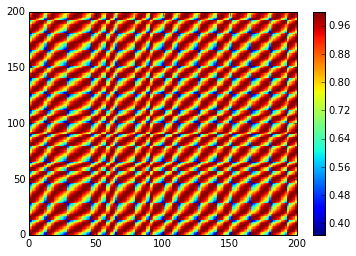

In [14]:
print Kl.shape
plt.pcolor(Kl[:200,:200])
plt.colorbar()

In [22]:
TP_ = np.repeat(np.array([175, 95, 93, 88, 10, 5, 180, 90, 80, 2, 170], ndmin = 2),21,axis=0)
TP = np.repeat(np.array(TP_.T,ndmin = 3),30,axis=0)
print TP.shape
MP = np.reshape(TP,(30*11*21,1))
print MP.shape
MP_c = MP[idx_com]
print MP_c.shape

(30, 11, 21)
(6930, 1)
(4157, 1)


In [133]:
#Kernel for pose
sigma = 40
Kp = kernel._get_kernel(MP_c, MP_c,'rbf', gamma=(2*sigma)**-2)

(4157, 4157)


<matplotlib.colorbar.Colorbar instance at 0x7f3919dcb368>

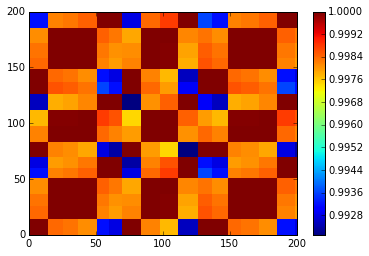

In [56]:
print Kp.shape
plt.pcolor(Kp[:200,:200])
plt.colorbar()

175 95 93 88 10 5 180 90 80 2 170


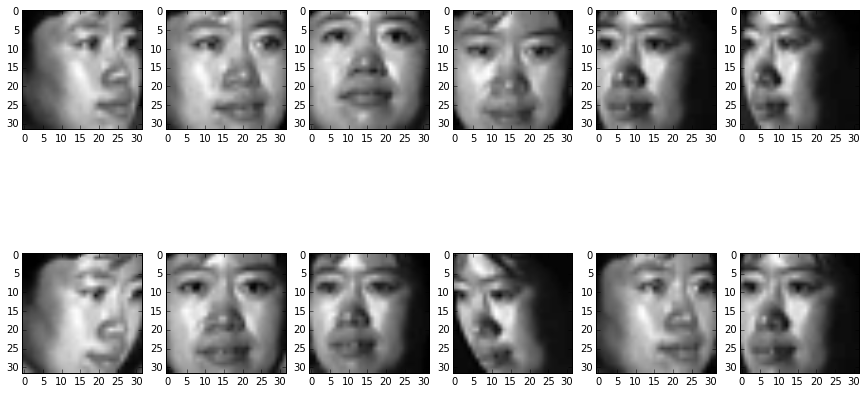

In [94]:
print TP[0,0,10],TP[0,1,10],TP[0,2,10],TP[0,3,10],TP[0,4,10],TP[0,5,10],TP[0,6,10],TP[0,7,10],TP[0,8,10],TP[0,9,10],TP[0,10,10]
f, axarr = plt.subplots(2, 6)
axarr[0,0].imshow( np.reshape(TF[0,0,10,:],(32,32)).T, cmap='Greys_r' )
axarr[0,1].imshow( np.reshape(TF[0,1,10,:],(32,32)).T, cmap='Greys_r' )
axarr[0,2].imshow( np.reshape(TF[0,2,10,:],(32,32)).T, cmap='Greys_r' )
axarr[0,3].imshow( np.reshape(TF[0,3,10,:],(32,32)).T, cmap='Greys_r' )
axarr[0,4].imshow( np.reshape(TF[0,4,10,:],(32,32)).T, cmap='Greys_r' )
axarr[0,5].imshow( np.reshape(TF[0,5,10,:],(32,32)).T, cmap='Greys_r' )
axarr[1,0].imshow( np.reshape(TF[0,6,10,:],(32,32)).T, cmap='Greys_r' )
axarr[1,1].imshow( np.reshape(TF[0,7,10,:],(32,32)).T, cmap='Greys_r' )
axarr[1,2].imshow( np.reshape(TF[0,8,10,:],(32,32)).T, cmap='Greys_r' )
axarr[1,3].imshow( np.reshape(TF[0,9,10,:],(32,32)).T, cmap='Greys_r' )
axarr[1,4].imshow( np.reshape(TF[0,10,10,:],(32,32)).T, cmap='Greys_r' )
axarr[1,5].imshow( np.reshape(TF[0,4,10,:],(32,32)).T, cmap='Greys_r' )
f.set_size_inches(15,8)

In [14]:
#Kernel for image
Ki = kernel._get_kernel(MF_c, MF_c,'linear')
print Ki.shape

(4157, 4157)


In [ ]:
#Kt = ks x Kp x kl x ki
#Kt = np.dot(np.dot(np.dot(Ks,Kp),Kl),Ki)
Kt = Ks*Kp*Kl*Ki
Kt.shape

In [ ]:
print Kt.shape
plt.pcolor(Kt[:400,:400])
plt.colorbar()

In [146]:
print Ks.shape,Kp.shape,Kl.shape,Ki.shape

(4158, 4158) (4158, 4158) (4158, 4158) (4158, 4158)


<h2>2.2 Computing Convex-NMF</h2>

$$\phi(X)\approx \phi(X)GH$$
$$\min||\phi(X) - \phi(X)GH||^2$$

$W = \phi(X)G$

<b>Parameters exploration:</b>

In [ ]:
#Exploring bases
bases = np.arange(2,Kt.shape[1]/32)
fopxt_c = np.ones(len(bases))
for idx,item in enumerate(bases):        
    cnmf_kt_c = CNMF(Kt, item)
    cnmf_kt_c.factorize(niter=10)
    fopxt_c[idx] = np.linalg.norm(Kt - np.dot(cnmf_kt_c.W,cnmf_kt_c.H))/np.linalg.norm(Kt)

min base  19


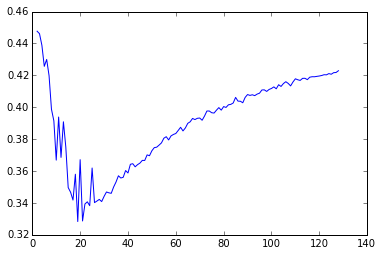

In [33]:
print "min base ", bases[np.argmin(fopxt_c)]
plt.plot(bases,fopxt_c)

In [35]:
#Exploring sigmas:
#Systematic experiments
import test_kcnmf
test_kcnmf.param_exp_sigma(MF_c,idx_com,19)

In [46]:
#Read Input
lines = np.loadtxt("/home/rajaquep/outcomes/cmu_faces_param_19oct2016.csv", comments="//", delimiter=";", skiprows=129, usecols=(1,2,3), unpack=False)

In [47]:
lines.shape
sigmav = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1e1, 1e2, 1e3, 1e4, 1e5 ]
sigmam = np.zeros((len(sigmav),len(sigmav)))
i,j = 0,0
for k in range(len(lines)):
    sigmam[i,j] = lines[k,2]
    j+=1
    if j==len(sigmav):
        i+=1
        j=0

min rse:  0.322393 with sigma illumination: 10000.0 sigma pose: 1000.0


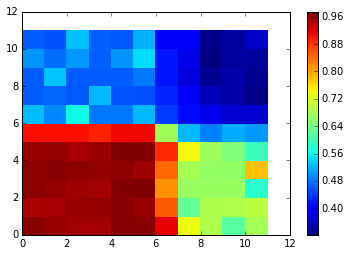

In [48]:
plt.pcolor(sigmam)
plt.colorbar()

print "min rse: ", min(lines[:,2]),"with sigma illumination:", lines[np.argmin(lines[:,2]),0], "sigma pose:", lines[np.argmin(lines[:,2]),1]


In [23]:
#Kernel for illumination
sigma = 10000.0
Kl = kernel._get_kernel(ML_c, ML_c,'rbf', gamma=(2*sigma)**-2)

In [24]:
#Kernel for pose
sigma = 1000.0
Kp = kernel._get_kernel(MP_c, MP_c,'rbf', gamma=(2*sigma)**-2)

In [25]:
#Kernel for image
Ki = kernel._get_kernel(MF_c, MF_c,'linear')
#print Ki.shape

In [26]:
#Kt = ks x Kp x kl x ki
#Kt = np.dot(np.dot(np.dot(Ks,Kp),Kl),Ki)
Kt = Ks*Kp*Kl*Ki
Kt.shape

(4157, 4157)

In [27]:
#Factorize
cnmf_kt_c = CNMF(Kt, num_bases=19)
cnmf_kt_c.factorize(niter=10)
print np.linalg.norm(Kt - np.dot(cnmf_kt_c.W,cnmf_kt_c.H))/np.linalg.norm(Kt)

0.36389900292


<h2>2.3 Completion: Finding $h_j$ to incomplete objects</h2>


Given an incomplete object $x_j$
$$\min_{h_j}||\phi(x_j)-\phi(X)Gh_j||^2$$
$$=\min_{h_j}h_j^TK(X,X)Gh_j - 2K(X,x_j)Gh_j$$
Using pseudo-inverse
$$h_j=(G^TK(X,X)G+\lambda I)^-1G^TK(X,x_j)$$

In [28]:
x = idx_inc[0]
print x

3


In [29]:
#complete object
#for each object x in idx_inc (MF[idx_inc] = MF_i)

#Kernel for illumination
sigma = 10000.0
Klx = kernel._get_kernel(ML_c, ML[x],'rbf', gamma=(2*sigma)**-2)
#Kernel for pose
sigma = 1000.0
Kpx = kernel._get_kernel(MP_c, MP[x],'rbf', gamma=(2*sigma)**-2)
#Kernel for image
Kix = kernel._get_kernel(MF_c, MF[x],'linear')
#Kernle for subject
#...

In [30]:
#Kernel for subject K(X_c,x_j)
j = x
Ksx = np.zeros((len(idx_com),1))
for i in range(len(idx_com)):
    if MS[i]==MS[j]: Ksx[i] = eq
    else: Ksx[i] = diff
print Ksx.shape

(4157, 1)


In [31]:
#Ktx = ksx x Kpx x klx x kix
#Ktx = np.dot(np.dot(np.dot(Ksx,Kpx),Klx),Kix)
Ktx= Ksx*Kpx*Klx*Kix


<i>(alternative 1)</i> If $Wh_j = x_j$, then $h_j = W^{+}x_j $. Without regularization

In [24]:
hj1 = np.dot(np.linalg.pinv(cnmf_kt_c.W),Ktx)

<i>(alternative 2)</i> $W^+ = (W^TW+\lambda I)^{-1}W^T$. When W has linealy independent columns. With regularization to guarante non singularity

In [25]:
lamb = 0
bases = 19
wpinv = np.dot( np.dot(cnmf_kt_c.W.T, cnmf_kt_c.W)+ lamb*np.identity(bases),cnmf_kt_c.W.T )

In [26]:
hj2 = np.dot(wpinv,Ktx)

In [27]:
Wpinv1 = np.linalg.pinv(cnmf_kt_c.W)

In [29]:
np.allclose(wpinv,Wpinv1)

False

In [31]:
print np.allclose( cnmf_kt_c.W, np.dot( np.dot(cnmf_kt_c.W, wpinv),cnmf_kt_c.W ) )
print np.allclose( cnmf_kt_c.W, np.dot( np.dot(cnmf_kt_c.W, Wpinv1),cnmf_kt_c.W ) )

False
True


<i>(alternative 3)</i> $W^+ = W^T(WW^T+\lambda I)^{-1}$. When $W$ has linealy independent rows. With regularization to guarante non singularity

In [32]:
lamb = 0
bases = 19
Wpinv2 = np.dot(cnmf_kt_c.W.T, np.linalg.inv( np.dot(cnmf_kt_c.W,cnmf_kt_c.W.T)+ lamb*np.identity(cnmf_kt_c.W.shape[0]) ) )

In [34]:
hj3 = np.dot(Wpinv2,Ktx)

In [35]:
print np.allclose( cnmf_kt_c.W, np.dot( np.dot(cnmf_kt_c.W, Wpinv2),cnmf_kt_c.W ) )
print np.allclose( cnmf_kt_c.W, np.dot( np.dot(cnmf_kt_c.W, Wpinv1),cnmf_kt_c.W ) )

False
True


<i>(alternative 4)</i> $h_j = (G^TK(X,X)G + \lambda I)^-1G^TK(X,x_j)$

In [43]:
lamb = 0
bases = 19
hj4 = np.dot( np.linalg.inv(np.dot(cnmf_kt_c.W.T, cnmf_kt_c.G)+ lamb*np.identity(bases)), np.dot(cnmf_kt_c.G.T, Ktx) )

In [44]:
hj4.shape

(19, 1)

Compute $h_j$ for each incomplete object $x_j$:

In [ ]:
lamb = 1e-5
bases = 19
sigmal = 10000.0
sigmap = 1000.0
H1_i = np.zeros((bases, len(idx_inc)))
H2_i = np.zeros((bases, len(idx_inc)))
H3_i = np.zeros((bases, len(idx_inc)))
H4_i = np.zeros((bases, len(idx_inc)))
k=0
for j in idx_inc:
    #Kernel for illumination
    Klx = kernel._get_kernel(ML_c, ML[j],'rbf', gamma=(2*sigmal)**-2)
    #Kernel for pose
    Kpx = kernel._get_kernel(MP_c, MP[j],'rbf', gamma=(2*sigmap)**-2)
    #Kernel for image
    Kix = kernel._get_kernel(MF_c, MF_ci[j],'linear')
    #Kix = kernel._get_kernel(MF_c, MF[j],'linear')
    #Kernle for subject
    #...
    Ksx = np.zeros((len(idx_com),1))
    for i in range(len(idx_com)):
        if MS[i]==MS[j]: Ksx[i] = eq
        else: Ksx[i] = diff
    #print Ksx.shape  
    Ktx = Ksx*Kpx*Klx*Kix
    H4_i[:,k] = np.squeeze(np.dot( np.linalg.inv(np.dot(cnmf_kt_c.W.T, cnmf_kt_c.G)+ lamb*np.identity(bases)), np.dot(cnmf_kt_c.G.T, Ktx) ))
    H3_i[:,k] = np.squeeze(np.dot(np.dot(cnmf_kt_c.W.T, np.linalg.inv( np.dot(cnmf_kt_c.W,cnmf_kt_c.W.T)+ lamb*np.identity(cnmf_kt_c.W.shape[0]) ) ),Ktx))
    H2_i[:,k] = np.squeeze(np.dot(np.dot( np.dot(cnmf_kt_c.W.T, cnmf_kt_c.W)+ lamb*np.identity(bases),cnmf_kt_c.W.T ),Ktx))
    H1_i[:,k] = np.squeeze(np.dot(np.linalg.pinv(cnmf_kt_c.W),Ktx))
    k+=1

In [59]:
Ktx.shape

(4158, 1)

In [20]:
#Factorization over the dataset without incompletion
Ks_ = kernel.softKernel(MF, 0.3, 1, 30)#subject
#Kernel for illumination
sigma = 10000.0
Kl_ = kernel._get_kernel(ML, ML,'rbf', gamma=(2*sigma)**-2)
#Kernel for pose
sigma = 1000.0
Kp_ = kernel._get_kernel(MP, MP,'rbf', gamma=(2*sigma)**-2)
#Kernel for image
Ki_ = kernel._get_kernel(MF, MF,'linear')
Kt_ = Ks_*Kp_*Kl_*Ki_
#Factorize
cnmf_kt = CNMF(Kt_, num_bases=19)
cnmf_kt.factorize(niter=10)
print np.linalg.norm(Kt_ - np.dot(cnmf_kt.W,cnmf_kt.H))/np.linalg.norm(Kt_)

0.3441742413


In [56]:
print np.linalg.norm(cnmf_kt.H[:,idx_inc]-H_i)

19.8098069853


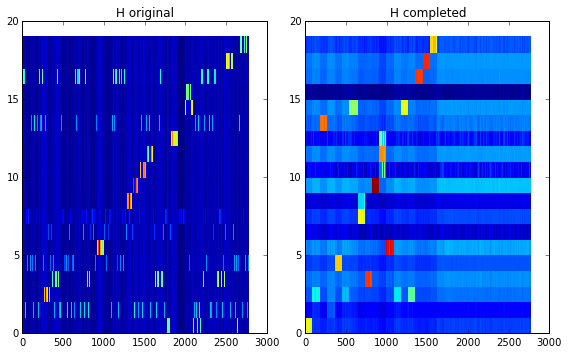

In [57]:
f, axarr = plt.subplots(1, 2)
axarr[0].pcolor(cnmf_kt.H[:,idx_inc])
axarr[0].set_title('H original')
axarr[1].pcolor(H_i)
axarr[1].set_title('H completed')
f.set_size_inches(8,5)
f.tight_layout()

In [182]:
np.linalg.norm(H_i)

12.078689367730354

<h2>2.4 Solve the pre-image problem</h2>

Given an incomplete object $x_j$
$$\phi(x_j) \approx \phi(X)Gh_j$$
The preimage problem consists of find $x*$ such that $\phi(x*) \approx \phi(x_j)$ or $$\phi(x*) \approx \phi(X)Gh_j$$

In [22]:
from kernelFaces import KernelFaces as KF

In [23]:
kf = KF(MF, idx_com)

In [24]:
print np.dot(cnmf_kt_c.W, H_i[:,0]).shape

(4158,)


In [25]:
sigmal = 10000.0
sigmap = 1000.0
#Pre-image reconstruction with H of completed objects
H_i_ref = cnmf_kt.H[:,idx_inc]
num_atts = MF_ci.shape[1]
num_bases = 19
MFpreim_ci = np.copy(MF_ci)
tic = time.clock()#get start time
for j in range(len(idx_inc)):
    print 'Compute pre-image for object',idx_inc[j]
    alpha = np.dot(cnmf_kt_c.W, H_i_ref[:,j]) #np.mean(cnmf_kg.H,0)
    MFpreim_ci[idx_inc[j]], trainErrorskl = kf.preimage_faces(MF_c, alpha, idx_inc[j],'cmu_softxrbfx3xlinear', sigmal,sigmap)    
toc = time.clock()#get final time
print 'Time: ',toc - tic

Compute pre-image for object 3
Compute pre-image for object 4
Compute pre-image for object 6
Compute pre-image for object 7
Compute pre-image for object 8
Compute pre-image for object 11
Compute pre-image for object 12
Compute pre-image for object 13
Compute pre-image for object 17
Compute pre-image for object 18
Compute pre-image for object 20
Compute pre-image for object 21
Compute pre-image for object 23
Compute pre-image for object 25
Compute pre-image for object 32
Compute pre-image for object 34
Compute pre-image for object 35
Compute pre-image for object 36
Compute pre-image for object 37
Compute pre-image for object 39
Compute pre-image for object 40
Compute pre-image for object 41
Compute pre-image for object 45
Compute pre-image for object 50
Compute pre-image for object 52
Compute pre-image for object 54
Compute pre-image for object 57
Compute pre-image for object 58
Compute pre-image for object 59
Compute pre-image for object 60
Compute pre-image for object 62
Compute pre-i

In [58]:
sigmal = 10000.0
sigmap = 1000.0
#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 19
MFpreim_ci = np.copy(MF_ci)
tic = time.clock()#get start time
for j in range(len(idx_inc)):
    print 'Compute pre-image for object',idx_inc[j]
    alpha = np.dot(cnmf_kt_c.W, H_i[:,j]) #np.mean(cnmf_kg.H,0)
    MFpreim_ci[idx_inc[j]], trainErrorskl = kf.preimage_faces(MF_c, alpha, idx_inc[j],'cmu_softxrbfx3xlinear', sigmal,sigmap)    
toc = time.clock()#get final time
print 'Time: ',toc - tic

Compute pre-image for object 3
Compute pre-image for object 4
Compute pre-image for object 6
Compute pre-image for object 7
Compute pre-image for object 8
Compute pre-image for object 11
Compute pre-image for object 12
Compute pre-image for object 13
Compute pre-image for object 17
Compute pre-image for object 18
Compute pre-image for object 20
Compute pre-image for object 21
Compute pre-image for object 23
Compute pre-image for object 25
Compute pre-image for object 32
Compute pre-image for object 34
Compute pre-image for object 35
Compute pre-image for object 36
Compute pre-image for object 37
Compute pre-image for object 39
Compute pre-image for object 40
Compute pre-image for object 41
Compute pre-image for object 45
Compute pre-image for object 50
Compute pre-image for object 52
Compute pre-image for object 54
Compute pre-image for object 57
Compute pre-image for object 58
Compute pre-image for object 59
Compute pre-image for object 60
Compute pre-image for object 62
Compute pre-i

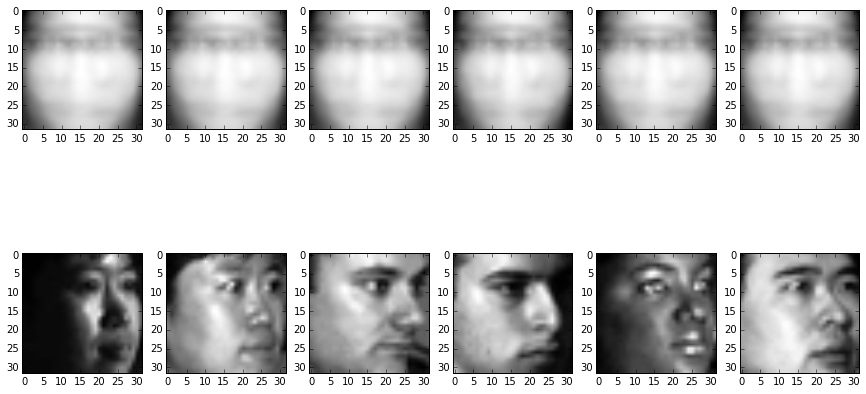

In [60]:
f, axarr = plt.subplots(2, 6)
axarr[0,0].imshow( np.reshape(MFpreim_ci[idx_inc[0],:],(32,32)).T, cmap='Greys_r' )
axarr[0,1].imshow( np.reshape(MFpreim_ci[idx_inc[10],:],(32,32)).T, cmap='Greys_r' )
axarr[0,2].imshow( np.reshape(MFpreim_ci[idx_inc[100],:],(32,32)).T, cmap='Greys_r' )
axarr[0,3].imshow( np.reshape(MFpreim_ci[idx_inc[1000],:],(32,32)).T, cmap='Greys_r' )
axarr[0,4].imshow( np.reshape(MFpreim_ci[idx_inc[2000],:],(32,32)).T, cmap='Greys_r' )
axarr[0,5].imshow( np.reshape(MFpreim_ci[idx_inc[2100],:],(32,32)).T, cmap='Greys_r' )
axarr[1,0].imshow( np.reshape(MF[idx_inc[0],:],(32,32)).T, cmap='Greys_r' )
axarr[1,1].imshow( np.reshape(MF[idx_inc[10],:],(32,32)).T, cmap='Greys_r' )
axarr[1,2].imshow( np.reshape(MF[idx_inc[100],:],(32,32)).T, cmap='Greys_r' )
axarr[1,3].imshow( np.reshape(MF[idx_inc[1000],:],(32,32)).T, cmap='Greys_r' )
axarr[1,4].imshow( np.reshape(MF[idx_inc[2000],:],(32,32)).T, cmap='Greys_r' )
axarr[1,5].imshow( np.reshape(MF[idx_inc[2100],:],(32,32)).T, cmap='Greys_r' )
f.set_size_inches(15,8)

In [55]:
print np.linalg.norm(np.reshape(MFpreim_ci[idx_inc[0],:],(32,32)) - np.reshape(MFpreim_ci[idx_inc[2000],:],(32,32)))
print np.linalg.norm(np.reshape(MF[idx_inc[2000],:],(32,32)) - np.reshape(MFpreim_ci[idx_inc[2000],:],(32,32)))

45.9672971989
2108.12013317


In [ ]:
#Systematic experiments
import test_kcnmf
test_kcnmf.test_cmu1(MF, sigmal = 10000.0, sigmap = 1000.0, bases = 19)

Compute pre-image for object 1
Compute pre-image for object 2
Compute pre-image for object 3
Compute pre-image for object 4
Compute pre-image for object 8
Compute pre-image for object 10
Compute pre-image for object 16
Compute pre-image for object 18
Compute pre-image for object 27
Compute pre-image for object 31
Compute pre-image for object 36
Compute pre-image for object 37
Compute pre-image for object 45
Compute pre-image for object 48
Compute pre-image for object 55
Compute pre-image for object 66
Compute pre-image for object 80
Compute pre-image for object 83
Compute pre-image for object 93
Compute pre-image for object 97
Compute pre-image for object 109
Compute pre-image for object 136
Compute pre-image for object 168
Compute pre-image for object 170
Compute pre-image for object 173
Compute pre-image for object 178
Compute pre-image for object 182
Compute pre-image for object 189
Compute pre-image for object 206
Compute pre-image for object 229
Compute pre-image for object 230
Co

In [33]:
#Read Input
lines2 = np.loadtxt("/home/rajaquep/outcomes/cmu_faces_26oct2016.csv", comments="//", delimiter=";", skiprows=2, usecols=(1,2,3,4,5,6), unpack=False)

In [39]:
missing_rates = [0.1, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98]

rse_cmu1_mean = []
for i in range(len(missing_rates)):
    rse_cmu1_mean.append( np.min(lines2[np.arange(i,lines2.shape[0],11),4]) )

In [40]:
#rse STDC
rse_stdc = [.1282, .1878, .2469, .2652, .3087, .2177, .4852, .6168, .7513, .8587, .9324]

In [45]:
#Read Input approach 1 to compare
lines = np.loadtxt("/home/rajaquep/outcomes/cmu_faces_12sep2016.csv", comments="//", delimiter=";", skiprows=1, usecols=(1,2,3,4,5), unpack=False)
rse_rbf = lines[np.arange(1,lines.shape[0],3),4]#rbf kernel
rse_rbf_mean = []
for i in range(len(missing_rates)):
    rse_rbf_mean.append( np.min(rse_rbf[np.arange(i,rse_rbf.shape[0],11)]) )

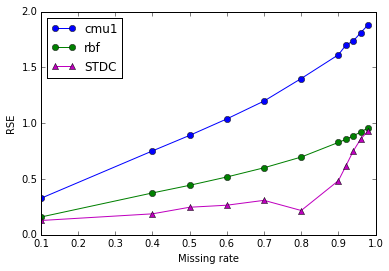

In [49]:
plt.plot(missing_rates,rse_cmu1_mean,'-ob',label='cmu1')
plt.plot(missing_rates,rse_rbf_mean,'-og',label='rbf')
#plt.plot(missing_rates,rse_linxrbf_mean,'-or',label='linxrbf')
#plt.plot(missing_rates,rse_softxlinxrbf_mean,'-oy',label='softxlinxrbf')
plt.plot(missing_rates,rse_stdc,'-^m',label='STDC')
plt.legend(loc=2)
plt.ylabel('RSE')
plt.xlabel('Missing rate')

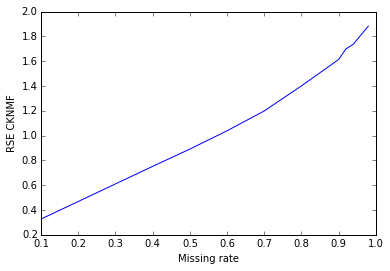

In [50]:

rse_fs_mean = []
for i in range(len(missing_rates)):
    rse_fs_mean.append( np.min(lines2[np.arange(i,lines2.shape[0],11),5]) )
    
plt.plot(missing_rates,rse_cmu1_mean)
plt.ylabel('RSE CKNMF')
plt.xlabel('Missing rate')

<h2>3.1 Tensorial Kernel for CMU Faces</h2>

 <ul style="list-style-type:disc">
  <li>Subject: rbf kernel $K_s$</li>
  <li>Pose: rbf kernel $K_p$</li>
  <li>Illumination: : rbf kernel $K_l$</li>
  <li>Image: rbf kernel $K_i$</li>
</ul> 

In [ ]:
#Exploring sigmas:
#Systematic experiments
import test_kcnmf
test_kcnmf.param_exp_sigma2(MF_c,idx_com,19)

In [ ]:
#Read Input
lines = np.loadtxt("/home/rajaquep/outcomes/cmu_faces_param_8nov2016.csv", comments="//", delimiter=",", skiprows=1, usecols=(1,2,3,4), unpack=False)

In [ ]:
#30x11x21x1024
eq = 1
diff = 0.3
poses = [175, 95, 93, 88, 10, 5, 180, 90, 80, 2, 170]
illuminations = np.arange(1,22)
TS = np.zeros((30,11,21))
for i in range(30):
    for j in range(len(poses)):
        for k in range(len(illuminations)):
            TS[i,j,k] = i
            
MS = np.reshape(TS,(30*11*21,1))


In [ ]:
#Kernel for subject
Ks = np.zeros((len(idx_com),len(idx_com)))
for i in range(len(idx_com)):
    for j in range(len(idx_com)):
        if MS[i]==MS[j]:
            Ks[i,j] = eq
        else:
            Ks[i,j] = diff
print Ks.shape        
#plt.pcolor(Ks[350:,350:])
#plt.colorbar()

In [63]:
#Kernel for illumination
sigma = 100.0
Kl = kernel._get_kernel(ML_c, ML_c,'rbf', gamma=(2*sigma)**-2)

In [ ]:
#Kernel for pose
sigma = 1000.0
Kp = kernel._get_kernel(MP_c, MP_c,'rbf', gamma=(2*sigma)**-2)

In [ ]:
#Kernel for image
sigma = 10000.0
Ki = kernel._get_kernel(MF_c, MF_c,'rbf', gamma=(2*sigma)**-2)
#print Ki.shape

In [ ]:
#Kt = ks x Kp x kl x ki
#Kt = np.dot(np.dot(np.dot(Ks,Kp),Kl),Ki)
Kt = Ks*Kp*Kl*Ki
Kt.shape

<h2>3.2 Completion: Finding $h_j$ to incomplete objects</h2>


Given an incomplete object $x_j$
$$\min_{h_j}||\phi(x_j)-\phi(X)Gh_j||^2$$
$$=\min_{h_j}h_j^TK(X,X)Gh_j - 2K(X,x_j)Gh_j$$
Using pseudo-inverse
$$h_j=(G^TK(X,X)G+\lambda I)^-1G^TK(X,x_j)$$

Compute $h_j$ for each incomplete object $x_j$:

In [ ]:
lamb = 1e-5
bases = 19
sigmal = 100.0
sigmap = 1000.0
sigmai = 10000.0
H1_i = np.zeros((bases, len(idx_inc)))
H2_i = np.zeros((bases, len(idx_inc)))
H3_i = np.zeros((bases, len(idx_inc)))
H4_i = np.zeros((bases, len(idx_inc)))
k=0
for j in idx_inc:
    #Kernel for illumination
    Klx = kernel._get_kernel(ML_c, ML[j],'rbf', gamma=(2*sigmal)**-2)
    #Kernel for pose
    Kpx = kernel._get_kernel(MP_c, MP[j],'rbf', gamma=(2*sigmap)**-2)
    #Kernel for image
    Kix = kernel._get_kernel(MF_c, MF_ci[j],'rbf', gamma=(2*sigmap)**-2)
    #Kix = kernel._get_kernel(MF_c, MF[j],'linear')
    #Kernle for subject
    #...
    Ksx = np.zeros((len(idx_com),1))
    for i in range(len(idx_com)):
        if MS[i]==MS[j]: Ksx[i] = eq
        else: Ksx[i] = diff
    #print Ksx.shape  
    Ktx = Ksx*Kpx*Klx*Kix
    H4_i[:,k]=np.squeeze(np.dot( np.linalg.inv(np.dot(cnmf_kt_c.W.T, cnmf_kt_c.G)+ lamb*np.identity(bases)), np.dot(cnmf_kt_c.G.T, Ktx) ))
    H3_i[:,k] = np.dot(np.dot(cnmf_kt_c.W.T, np.linalg.inv( np.dot(cnmf_kt_c.W,cnmf_kt_c.W.T)+ lamb*np.identity(cnmf_kt_c.W.shape[0]) ) ),Ktx)
    H2_i[:,k] = np.dot(np.dot( np.dot(cnmf_kt_c.W.T, cnmf_kt_c.W)+ lamb*np.identity(bases),cnmf_kt_c.W.T ),Ktx)
    H1_i[:,k] = np.dot(np.linalg.pinv(cnmf_kt_c.W),Ktx)
    k+=1

<h2>2.4 Solve the pre-image problem</h2>

Given an incomplete object $x_j$
$$\phi(x_j) \approx \phi(X)Gh_j$$
The preimage problem consists of find $x*$ such that $\phi(x*) \approx \phi(x_j)$ or $$\phi(x*) \approx \phi(X)Gh_j$$

In [ ]:
sigmal = 10000.0
sigmap = 1000.0
sigmai = 1000.0

#Pre-image reconstruction
num_atts = MF_ci.shape[1]
num_bases = 19
MFpreim_ci = np.copy(MF_ci)
tic = time.clock()#get start time
for j in range(len(idx_inc)):
    print 'Compute pre-image for object',idx_inc[j]
    alpha = np.dot(cnmf_kt_c.W, H_i[:,j]) #np.mean(cnmf_kg.H,0)
    MFpreim_ci[idx_inc[j]], trainErrorskl = kf.preimage_faces(MF_c, alpha, idx_inc[j],'cmu_softxrbfx3xlinear', sigmal,sigmap)    
    kernel.preimage(MF_c, alpha, 'rbf', gamma=(2*sigmal)**-2+(2*sigmap)**-2+(2*sigmai)**-2)
toc = time.clock()#get final time
print 'Time: ',toc - tic